In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

In [272]:
option_PNL = pd.read_csv('option_PNL.csv', index_col=0)

In [273]:
real_PNL = pd.read_csv('option_PNL_real.csv', index_col=0)

In [235]:
quote_dates = option_PNL.index.unique()

In [236]:
# replace nasdaq with the predicted expiration price

nasdaq = pd.read_csv('NASDAQ.csv')
nasdaq['Date']=pd.to_datetime(nasdaq['Date'])

In [237]:
# find pnl matrix

def generate_pnl(pnl):
    call_PNL = pnl.pivot(index='quote_date', columns='no', values='pnl_long_Call')
    put_PNL = pnl.pivot(index='quote_date', columns='no', values='pnl_long_Put')
    call_S_PNL = pnl.pivot(index='quote_date', columns='no', values='pnl_short_Call')
    put_S_PNL = pnl.pivot(index='quote_date', columns='no', values='pnl_short_Put') 
    call_PNL.columns = [f"{col}_C" for col in call_PNL.columns]
    put_PNL.columns = [f"{col}_P" for col in put_PNL.columns]
    call_S_PNL.columns = [f"{col}_C_S" for col in call_S_PNL.columns]
    put_S_PNL.columns = [f"{col}_P_S" for col in put_S_PNL.columns]
    option_PNL = pd.merge(call_PNL , put_PNL, left_on = 'quote_date', right_on = 'quote_date')
    option_PNL = pd.merge(option_PNL , call_S_PNL, left_on = 'quote_date', right_on = 'quote_date')
    option_PNL = pd.merge(option_PNL , put_S_PNL, left_on = 'quote_date', right_on = 'quote_date')

    return option_PNL

In [274]:
import cvxpy as cp

def optimize(option_PNL, gamma, lam, graph = False, edge = 0.03):
    # Generate Sigma as a random PSD n*n matrix,  would be substituded by the covariance matrix
    # # mu as a random n-vector, would be substituded by the expected return
    mu = option_PNL.mean().to_numpy()
    n = len(mu)
    Sigma = option_PNL.cov()
    # gamma = 0.0005
    # lam = 10000000
    # Sigma_1 = Sigma + lam * np.identity(n)
    Sigma = cp.psd_wrap(Sigma)
    # constraints 
    # h=0_n, A=1_n, b=1
    # Gw >= h equiv to w_i>=0 for all i
    # Aw = b equiv to sum(w_i)=1
    h = np.zeros(n)
    A = np.ones(n)
    b = 1

    # Define and solve the CVXPY problem.
    w = cp.Variable(n)
    prob = cp.Problem(cp.Minimize((1/2) * gamma * cp.quad_form(w, Sigma) + (1/2) * lam * cp.quad_form(w, np.identity(n)) - mu.T @ w),
                [
                    w >= h,
                    # A.T @ w == b
                    ])
    prob.solve(solver = cp.OSQP, verbose=False, eps_abs=1e-20)

    # # Print result.
    # print("\nThe optimal value is", prob.value)
    # print("A solution w is")
    # print(w.value)
    if graph == True:
        # graph weights vs strike, see if at 1 it is a peak/valley
        m = n//4

        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
        # plt.grid()
        ax[0][0].scatter(option_PNL.columns[:m], w.value[:m])
        ax[0][0].axhline(y=0)
        ax[0][0].axvline(x=m//2,linestyle = 'dashed', color='r')
        ax[0][0].tick_params(labelrotation=90)
        ax[0][0].set_ylim(-edge,edge)
        ax[0][0].set_title('Long Call')

        ax[0][1].scatter(option_PNL.columns[m:2*m], w.value[m:2*m])
        ax[0][1].tick_params(labelrotation=90)
        ax[0][1].axhline(y=0)
        ax[0][1].axvline(x=m//2,linestyle = 'dashed', color='r')
        ax[0][1].set_ylim(-edge,edge)
        ax[0][1].set_title('Long Put')

        ax[1][0].scatter(option_PNL.columns[2*m:3*m], w.value[2*m:3*m])
        ax[1][0].tick_params(labelrotation=90)
        ax[1][0].axhline(y=0)
        ax[1][0].axvline(x=m//2,linestyle = 'dashed', color='r')
        ax[1][0].set_ylim(-edge,edge)
        ax[1][0].set_title('Short Call')

        ax[1][1].scatter(option_PNL.columns[3*m:], w.value[3*m:])
        ax[1][1].tick_params(labelrotation=90)
        ax[1][1].axhline(y=0)
        ax[1][1].axvline(x=m//2,linestyle = 'dashed', color='r')
        ax[1][1].set_ylim(-edge,edge)
        ax[1][1].set_title('Short Put')

        plt.show()
    return w.value

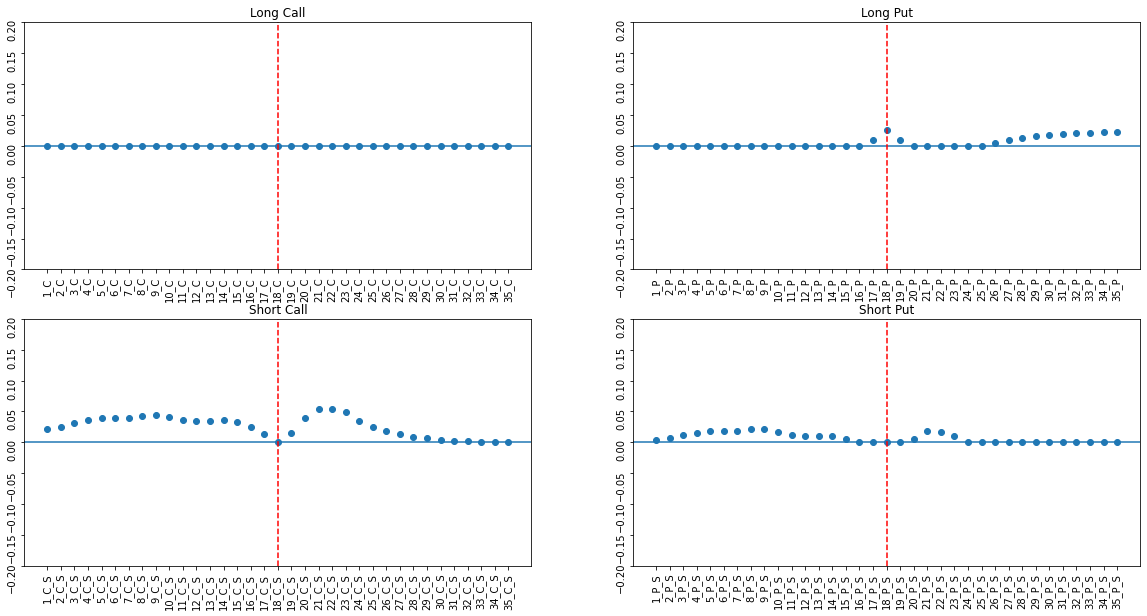

In [276]:
w = optimize(option_PNL, gamma=0.001, lam=1000, graph = True, edge=0.2)

In [ ]:
lam = 1000
w = optimize(option_PNL, gamma=0.001, lam=1000, graph = True, edge=0.5)

In [277]:
mu = option_PNL.mean().to_numpy()
Sigma = option_PNL.cov()
print('fake profit:', w.T @ mu)
print('fake standard deviation:', np.sqrt(w.T @ Sigma @ w))

fake profit: 233.38287549149814
fake standard deviation: 438.77648813631566


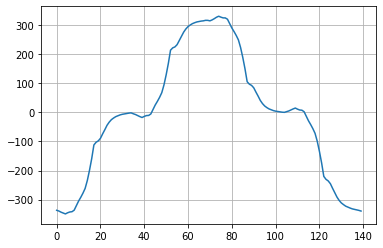

In [278]:
plt.grid()
plt.plot(mu)

In [279]:
mu = real_PNL.mean().to_numpy()
Sigma = real_PNL.cov()
print('real profit:', w.T @ mu)
print('real standard deviation:', np.sqrt(w.T @ Sigma @ w))

real profit: -77.3054007470986
real standard deviation: 497.84645795667103


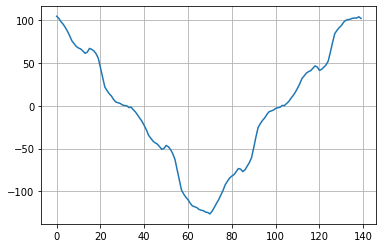

In [280]:
plt.grid()
plt.plot(mu)

In [251]:
# # check if there exist long and short positions for the same strike simulataneously
# print((abs(w[:m]*w[2*m:3*m])>1e-25).sum())
# print((abs(w[m:2*m]*w[3*m:])>1e-25).sum())

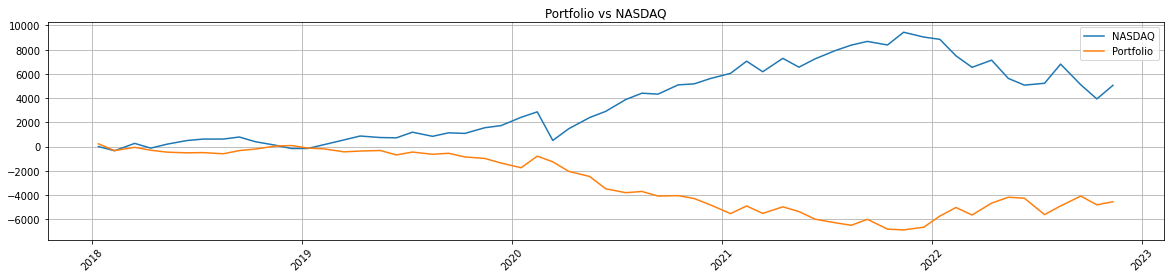

In [282]:
def plot_portfolio_vs_NASDAQ(option_PNL, nasdaq, w_opt): 
    portfolio = np.cumsum(option_PNL@w_opt.T)
    portfolio.index = pd.to_datetime(portfolio.index)   

    nasdaq_1 = nasdaq[nasdaq['Date'].isin(quote_dates)]
    nasdaq_1.set_index('Date', inplace=True)

    plt.figure(figsize=(20,4))
    plt.grid()
    plt.plot(nasdaq_1['Close/Last']-nasdaq_1.loc['2018-01-12', ['Close/Last']].values[0], label='NASDAQ')
    plt.plot(portfolio, label = 'Portfolio')
    plt.xticks(rotation=45)
    plt.legend()
    plt.title('Portfolio vs NASDAQ')
    plt.show()
plot_portfolio_vs_NASDAQ(real_PNL, nasdaq, w)

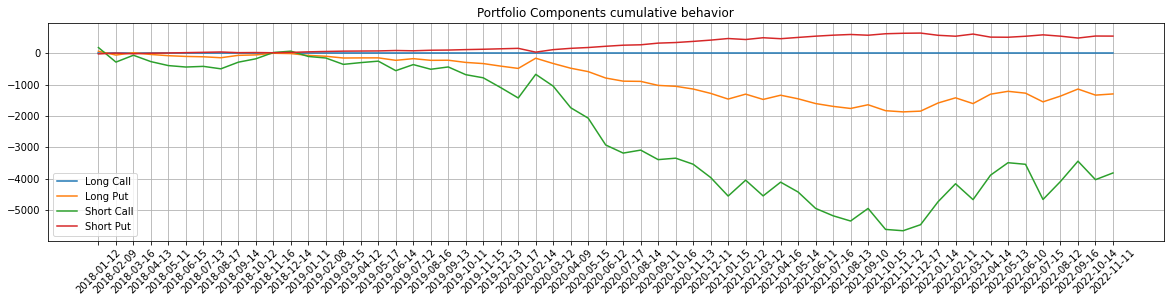

In [283]:
m=35
def plot_component(option_PNL, w_opt):
    plt.figure(figsize=(20,4))
    plt.grid()
    plt.plot(np.cumsum(option_PNL.iloc[:,:m*1]@w_opt[:m*1].T), label='Long Call')
    plt.plot(np.cumsum(option_PNL.iloc[:,m*1:m*2]@w_opt[m*1:m*2].T), label='Long Put')
    plt.plot(np.cumsum(option_PNL.iloc[:,m*2:m*3]@w_opt[m*2:m*3].T), label='Short Call')  
    plt.plot(np.cumsum(option_PNL.iloc[:,m*3:m*4]@w_opt[m*3:m*4].T),label = 'Short Put')
    plt.xticks(rotation=45)
    plt.legend()
    plt.title('Portfolio Components cumulative behavior')
    plt.show()
plot_component(real_PNL, w)

In [195]:
for gamma in [0.00001,0.0001,0.001, 0.1, 1, 10, 100]:
    for lam in [1000, 10000,100000,1000000,10000000]:
        w = optimize(option_PNL, gamma, lam)
        # mu = real_PNL.mean().to_numpy()
        # Sigma = real_PNL.cov()
        # print('real profit:', w.T @ mu)
        # print('real standard deviation:', np.sqrt(w.T @ Sigma @ w))
        mu = option_PNL.mean().to_numpy()
        Sigma = option_PNL.cov()
        if np.sqrt(w.T @ Sigma @ w)<1000 and np.sqrt(w.T @ Sigma @ w)>100:
            print('gamma:', gamma, 'lambda:', lam)
            print('fake profit:', w.T @ mu)
            print('fake standard deviation:', np.sqrt(w.T @ Sigma @ w))
            print('----------------------------------')

gamma: 0.001 lambda: 10000000
fake profit: 2085.5615547175285
fake standard deviation: 811.2557070619603
----------------------------------


In [212]:
# plt.figure(figsize=(20,4))
# plt.grid()
# plt.plot(option_PNL.iloc[:,:m*1]@w_opt[:m*1].T, label='Long Call')
# plt.plot(option_PNL.iloc[:,m*1:m*2]@w_opt[141*1:141*2].T, label='Long Put')
# plt.plot(option_PNL.iloc[:,m*2:m*3]@w_opt[141*2:141*3].T, label='Short Call')
# plt.plot(option_PNL.iloc[:,m*3:m*4]@w_opt[141*3:141*4].T,label = 'Short Put')
# plt.xticks(rotation=45)
# plt.legend()
# plt.title('Portfolio Components daily behavior')
# plt.show()

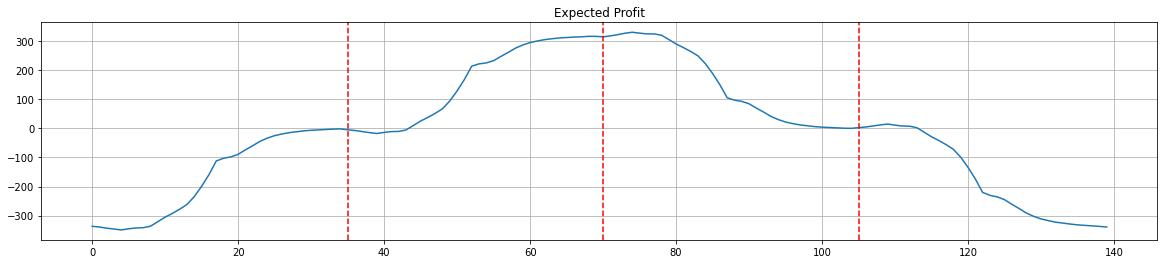

In [284]:
mu = option_PNL.mean().to_numpy()
plt.figure(figsize=(20,4))
plt.grid()
plt.plot(mu)
plt.axvline(x=len(mu)//4, linestyle = 'dashed', color='r')
plt.axvline(x=len(mu)//2, linestyle = 'dashed', color='r')
plt.axvline(x=len(mu)*3//4, linestyle = 'dashed', color='r')
plt.title('Expected Profit')
plt.show()